# Data Preparation and Analysis Notebook
## Defining the representation, data extraction, cleaning, preprocessing, and visualisation

In this Jupyter notebook we first need to define the representation that we will be using for our model.

One approach is to consider the fragmentation of the tumour via its cancer cells. If the cancer cells are highly clustered, then the T cells will have an easier time containing their spread and thus reducing the likelihood of penetration into the bloodstream. If this happens then the cancer can spread rapidly and increase the likelihood of a fatality. 

Following from this idea of fragmentation, the idea is to define a neighbouring relation between cells. If they are close enough to each other, we say that they are in the same 'bud', or 'cluster'. A cluster is then defined as a collection of cells where for each c in the cluster, there exists another cell c' such that c and c' are neighbours according to our neighbouring relation.

We'll take a histogram of the frequencies of the sizes of these clusters, from 1 to 20 and 21+. This gives us a homogenous, relatively low-dimensional (n=21) input to our classifier.

The data is passed in as a large Excel file with various fields. Once those were cleaned up, we had just 7 columns, being xMin, xMax, yMin, yMax of the bounding boxes surrounding the cells, and three classes indicating whether the cell was a cancer cell, a general T cell, or a cytotoxic T cell. Note that 'lymphocytes' are a superset of T cells.

Now that we've defined a feature representation to give to our model, let's go about getting our representation.

In [25]:
# Watermark for reproducibility of results
%load_ext watermark
%watermark -a 'Daniel Soutar' -d -nrmv --packages numpy,pandas,sklearn,matplotlib,seaborn,imblearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [2]:
# Imports
import Cluster
import cProfile
import glob
import partition
import pickle
import strip
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import pandas as pd
import seaborn as sb
from imblearn.over_sampling import ADASYN, SMOTE

# Note to self: reference this in final report submission.
# @article{JMLR:v18:16-365,
# author  = {Guillaume  Lema{{\^i}}tre and Fernando Nogueira and Christos K. Aridas},
# title   = {Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning},
# journal = {Journal of Machine Learning Research},
# year    = {2017},
# volume  = {18},
# number  = {17},
# pages   = {1-5},
# url     = {http://jmlr.org/papers/v18/16-365}
# }

In [3]:
## Loading
example = open('./examples/_DONEIN700-SN142.p', 'rb')
input_list = pickle.load(example)
print(len(input_list))

174257


In [4]:
# Splitting cells up by their class
cancer_cells = []
T_cells = []
cyto_T_cells = []

for i, row in enumerate(input_list):
    row = [ int(x) for x in row ]
    
    if row[4] > 0:
        cancer_cells.append([row[0], row[1], row[2], row[3]])
    if row[5] > 0:
        T_cells.append([row[0], row[1], row[2], row[3]])
    if row[6] > 0:
        cyto_T_cells.append([row[0], row[1], row[2], row[3]])
        
cancer_cells = np.asarray(cancer_cells)
T_cells = np.asarray(T_cells)
cyto_T_cells = np.asarray(cyto_T_cells)

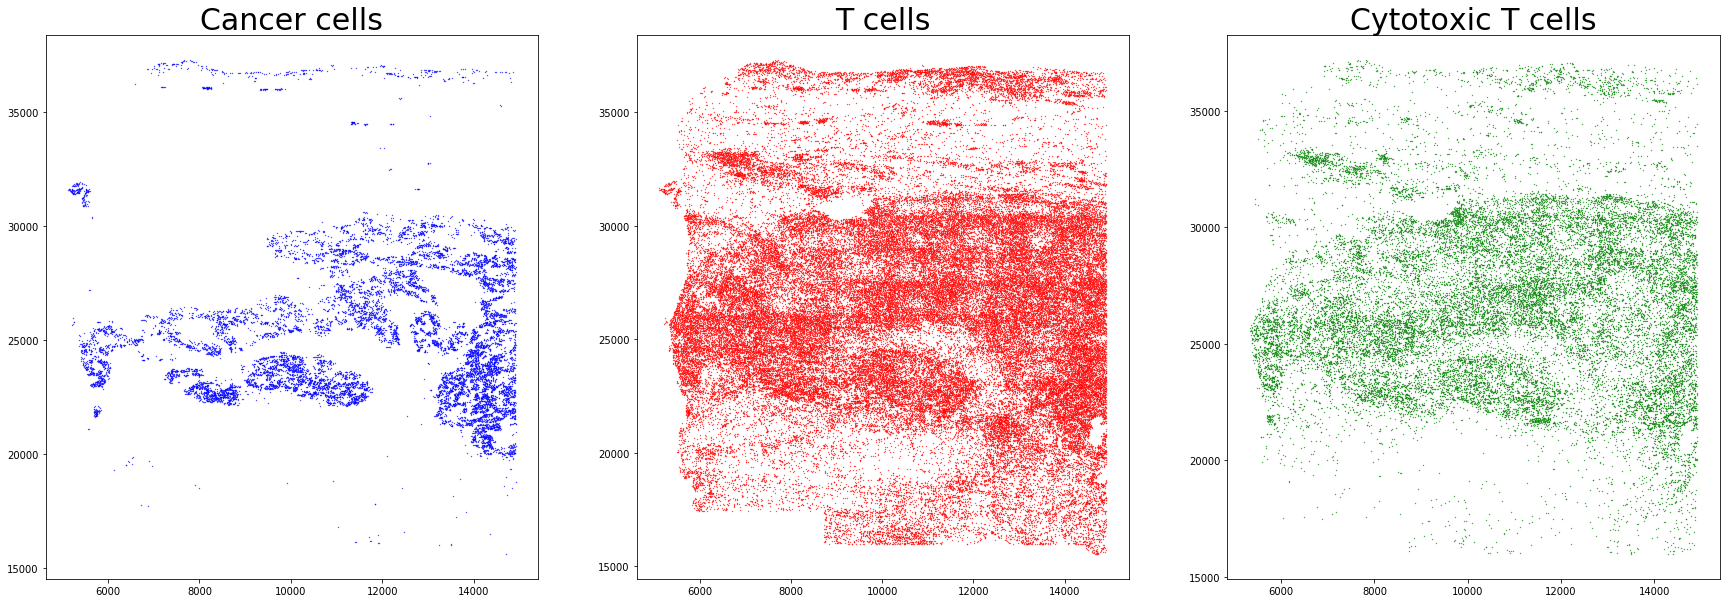

In [5]:
# Let's first visualise the input to make sure our data 'looks' as we would expect it to.
cancer_cells_xAvg = np.mean(np.array([cancer_cells[:,0], cancer_cells[:,1]]), axis=0)
cancer_cells_yAvg = np.mean(np.array([cancer_cells[:,2], cancer_cells[:,3]]), axis=0)

T_cells_xAvg = np.mean(np.array([T_cells[:,0], T_cells[:,1]]), axis=0)
T_cells_yAvg = np.mean(np.array([T_cells[:,2], T_cells[:,3]]), axis=0)

cyto_T_cells_xAvg = np.mean(np.array([cyto_T_cells[:,0], cyto_T_cells[:,1]]), axis=0)
cyto_T_cells_yAvg = np.mean(np.array([cyto_T_cells[:,2], cyto_T_cells[:,3]]), axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.set_title('Cancer cells', fontsize=30)
ax1.scatter(cancer_cells_xAvg, cancer_cells_yAvg, s=0.1, c='b')

ax2.set_title('T cells', fontsize=30)
ax2.scatter(T_cells_xAvg, T_cells_yAvg, s=0.1, c='r')

ax3.set_title('Cytotoxic T cells', fontsize=30)
ax3.scatter(cyto_T_cells_xAvg, cyto_T_cells_yAvg, s=0.1, c='g')

plt.show(fig)

In [8]:
def get_histo(clusters):
    histogram = np.zeros(21, dtype=np.uint32)
    total_cluster_cells = 0
    for cluster in clusters:
        if cluster is None:
            raise TypeError
        value = len(cluster.cells)
        total_cluster_cells += len(cluster.cells)
        if value > 20:
            histogram[20] += 1
        else:
            histogram[value - 1] += 1
    return histogram, total_cluster_cells

100%|██████████| 25/25 [00:00<00:00, 1098.71it/s]


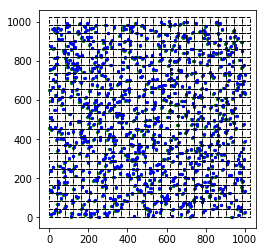

1000it [00:01, 621.72it/s]
100%|██████████| 25/25 [00:00<00:00, 40.05it/s]s]


In [58]:
# Example cases for clustering algorithms - this is where I visualised the various inputs for test.py
NUM_POINTS = 1000

check_again = False

if not check_again:
    random_xMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
#     random_xMin = np.arange(NUM_POINTS)
    random_xMax = np.copy(random_xMin) + 3
    random_yMin = np.random.choice(range(NUM_POINTS + 1), size=NUM_POINTS, replace=False)
#     random_yMin = np.arange(NUM_POINTS)
    random_yMax = np.copy(random_yMin) + 3
    random_points = np.stack((random_xMin, random_xMax, random_yMin, random_yMax), 0).transpose()

t = 25
partitioned_random_points, windows_list, w, h = partition.partition(random_points, tile_size=t, to_list=True)
flattened_windows_list = np.array(windows_list).reshape((t*t, 4))

# Check that the partitioning of the input maintains all the cells
partitioned_total = 0
for i in range(t):
    for j in range(t):
        partitioned_total += len(partitioned_random_points[i][j])

assert(partitioned_total == NUM_POINTS)

fig = plt.figure()
ax1 = fig.add_subplot(111, aspect='equal')

ax1.scatter(random_points[:,0], random_points[:,2], s=5, c='g')
ax1.scatter(random_points[:,1], random_points[:,3], s=5, c='b')

for window in flattened_windows_list:
    xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
    ax1.add_patch(
        patches.Rectangle(
            (xMin, yMin),   # (x,y)
            xMax - xMin,    # width
            yMax - yMin,    # height
            linestyle='--',
            fill=False
        )
    )

plt.show()

Cluster_result1 = Cluster.simplest(random_points)
Cluster_result2 = Cluster.fishermans_algorithm(partitioned_random_points, t, windows_list, w, h)

non_duplicates = set()

# # # Simplest
for key, value in Cluster_result1.items():
    if value not in non_duplicates:
        non_duplicates.add(value)

assert(len(non_duplicates) == len(Cluster_result2))

histo1, total_cluster_cells1 = get_histo(non_duplicates)
histo2, total_cluster_cells2 = get_histo(Cluster_result2)

assert(total_cluster_cells1 == total_cluster_cells2 and np.array_equal(histo1, histo2))

In [10]:
t = 25
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
print("cells partitioned ...")

100%|██████████| 25/25 [00:00<00:00, 348.56it/s]

cells partitioned ...


The simplest algorithm starts off slowly, as we expect - given that it compares each cell against almost every other cell.
The iterations/s does increase over time though, due to the small optimisation that once we check a cell against
all of its neighbours, we never check it again. This results in time complexity **roughly** of O(n^2 / 2).
One can actually calculate the exact number of comparisons that will be made as a consequence:

 num_comparisons = ((n-1)^2 + (n-1)) / 2    (Subtract 1 from n to account for not checking self for neighbourhood)

For n = 13804, num_comparisons = (13803^2 + 13803) / 2 = 95,268,306. The profiler confirms this in the number of calls to Cluster.are_neighbours().

In [11]:
cProfile.run("Cluster.simplest(cancer_cells)")

13804it [05:12, 44.13it/s]


         95717726 function calls in 312.810 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:147(__enter__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:58(__init__)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:78(acquire)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:936(_find_and_load_unlocked)
        1    0.000   

The fishermans algorithm as of 25/1/18 is M I L E S faster than the simple one above, completing in around 10 
or so seconds in comparison to 3.5 to 5 minutes for the one above.
This algorithm makes 2209284 neighbour comparisons in comparison to the above algorithm's 95268306.
That's a difference of nearly 2 orders of magnitude already, and this is for a comparatively very small example. 
Bigger ones, the gap becomes VAST. Investing time into developing this algorithm was definitely a wise move.

One cannot very easily give an estimate of the number of comparisons made because it becomes dependent
on the partitioning of the input, but a rough lower bound would be:

num_comparisons = T * (((n-1)/T)^2 + ((n-1)/T)) / 2     (perfect partitioning, same number of cells per tile, no cells overlapping tiles)

where T is the total number of tiles, or t * t with t as the tiling parameter. 

The exact upper bound on time complexity is (n-1(n-1 + 1)) / 2 as above (assuming that only one tile contains the 
entire input). Since our tiling function partitions the input based on its values, we know that the fisherman's
algorithm will be at least as fast as this. For t=1, the fisherman's algorithm performs identically with the simplest algorithm above in terms of speed.

In [12]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, tile_size=t, to_list=True)
cProfile.run("Cluster.fishermans_algorithm(partitioned_cancer_cells, t, windows, w, h)")

100%|██████████| 25/25 [00:12<00:00,  1.95it/s]/s]


         2891022 function calls in 12.854 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:103(release)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:143(__init__)
       26    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:147(__enter__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:151(__exit__)
       26    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:176(cb)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:58(__init__)
       26    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:78(acquire)
       26    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:936(_find_and_load_unlocked)
       26    0.000    0

In [6]:
partitioned_cancer_cells, windows, w, h = partition.partition(cancer_cells, to_list=True)
result = Cluster.fishermans_algorithm(partitioned_cancer_cells, 25, windows, w, h)

100%|██████████| 25/25 [00:11<00:00,  2.23it/s]/s]


In [11]:
# WARNING: this section of code is very slow! Do not run if it's not necessary!

def mean(arr):
    return sum(arr) / len(arr)

xMin = [[] for n in range(21)]
xMax = [[] for n in range(21)]
yMin = [[] for n in range(21)]
yMax = [[] for n in range(21)]

xMin_means = []
xMax_means = []
yMin_means = []
yMax_means = []

cell_total = 0

# Set up the figure 
fig = plt.figure(figsize=(80, 60), dpi=300)
ax1 = fig.add_subplot(111, aspect='equal')

for cluster in tqdm(result):
    j = 20 if len(cluster.cells) >= 21 else len(cluster.cells)-1
    cell_total += len(cluster.cells)
    cluster_xMin, cluster_xMax, cluster_yMin, cluster_yMax = [], [], [], []

    for i, item in enumerate(cluster.cells):
        if i == 0:
            cluster_xMin.append(item[0])
            cluster_xMax.append(item[1])
            cluster_yMin.append(item[2])
            cluster_yMax.append(item[3])
        else:
            cluster_xMin.append(item[0][0])
            cluster_xMax.append(item[0][1])
            cluster_yMin.append(item[0][2])
            cluster_yMax.append(item[0][3])
    
    xMin_mean = mean(cluster_xMin)
    xMax_mean = mean(cluster_xMax)
    yMin_mean = mean(cluster_yMin)
    yMax_mean = mean(cluster_yMax)
    
    for i, cell in enumerate(cluster.cells):
        if i == 0:
            cell_centre_x, cell_centre_y = (cell[0] + cell[1]) / 2, (cell[2] + cell[3]) / 2
        else:
            cell_centre_x, cell_centre_y = (cell[0][0] + cell[0][1]) / 2, (cell[0][2] + cell[0][3]) / 2
        x_mean, y_mean = (xMin_mean + xMax_mean) / 2, (yMin_mean + yMax_mean) / 2
        ax1.plot([cell_centre_x, x_mean], [cell_centre_y, y_mean], 'r-', linewidth=0.02)
    
    xMin_means.append(xMin_mean)
    xMax_means.append(xMax_mean)
    yMin_means.append(yMin_mean)
    yMax_means.append(yMax_mean)
    
    xMin[j].extend(cluster_xMin)
    xMax[j].extend(cluster_xMax)
    yMin[j].extend(cluster_yMin)
    yMax[j].extend(cluster_yMax)
        
actual = 0
for category in xMin:
    for sub_category in category:
        actual += 1

assert(cell_total == actual)

for i, j, k, l in zip(xMin, xMax, yMin, yMax):
    assert(len(i) == len(j) == len(k) == len(l))
        
xMin_mod = [np.array(xi) for xi in xMin]
xMax_mod = [np.array(xi) for xi in xMax]
yMin_mod = [np.array(xi) for xi in yMin]
yMax_mod = [np.array(xi) for xi in yMax]

actual = 0
for category in xMin_mod:
    for sub_category in category:
        actual += 1

assert(cell_total == actual)

x_means = np.mean(np.stack((np.array(xMin_means), np.array(xMax_means)), axis=1), axis=1)
y_means = np.mean(np.stack((np.array(yMin_means), np.array(yMax_means)), axis=1), axis=1)

# Colours for the cells
colours = ["black", "blue", "red", "green", "cyan", "indigo", "orange"]

for i in range(21):
    index = i if i < len(colours)-1 else len(colours)-1
    
    local_x = np.mean(np.column_stack((xMin_mod[i], xMax_mod[i])), axis=1)
    local_y = np.mean(np.column_stack((yMin_mod[i], yMax_mod[i])), axis=1)
    if i == 20:
        my_label = "size " + str(i+1) + "+"
    else:
        my_label = "size " + str(i+1)
    ax1.scatter(local_x, local_y, s=0.1, c=colours[index], label=my_label)

ax1.scatter(x_means, y_means, s=1, c="purple")

flattened_windows_list = np.array(windows).reshape((25*25, 4))

# for window in flattened_windows_list:
#     xMin, yMin, xMax, yMax = window[0], window[1], window[2], window[3]
#     ax1.add_patch(
#         patches.Rectangle(
#             (xMin, yMin),   # (x,y)
#             xMax - xMin,    # width
#             yMax - yMin,    # height
#             linestyle='--',
#             fill=False
#         )
#     )
plt.legend()
plt.show()

100%|██████████| 2644/2644 [03:15<00:00, 13.55it/s]


Sum: 0.9999999962747097
[0.4822239  0.16792738 0.08434191 0.05219365 0.03366112 0.02571861
 0.01928896 0.01853253 0.01134644 0.00832073 0.00794251 0.00642965
 0.00605144 0.00567322 0.00378215 0.00642965 0.00453858 0.00340393
 0.0026475  0.00491679 0.04462935]


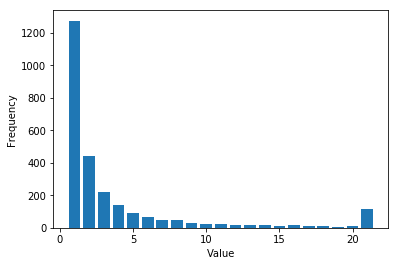

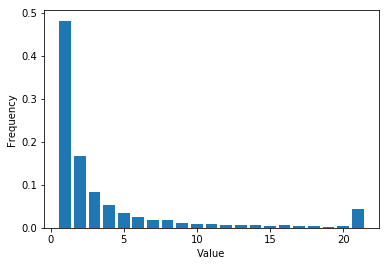

In [15]:
fig = plt.figure()

histogram, total_cluster_cells1 = get_histo(result)

histogram_normed = histogram.astype(np.float32)
        
my_sum = sum(histogram_normed)

aggregate = 0

for i, x in enumerate(histogram_normed):
    aggregate += histogram_normed[i] / my_sum
    histogram_normed[i] /= my_sum
    
print("Sum:", np.sum(histogram_normed, dtype=np.float64))
    
    
y_normed = np.array(histogram_normed, dtype=np.float32)
print(y_normed)
y = np.array(histogram)
x = np.arange(21) + 1

plt.bar(x, y)
plt.xlabel("Value")
plt.ylabel("Frequency")
fig = plt.figure()
plt.bar(x, y_normed)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

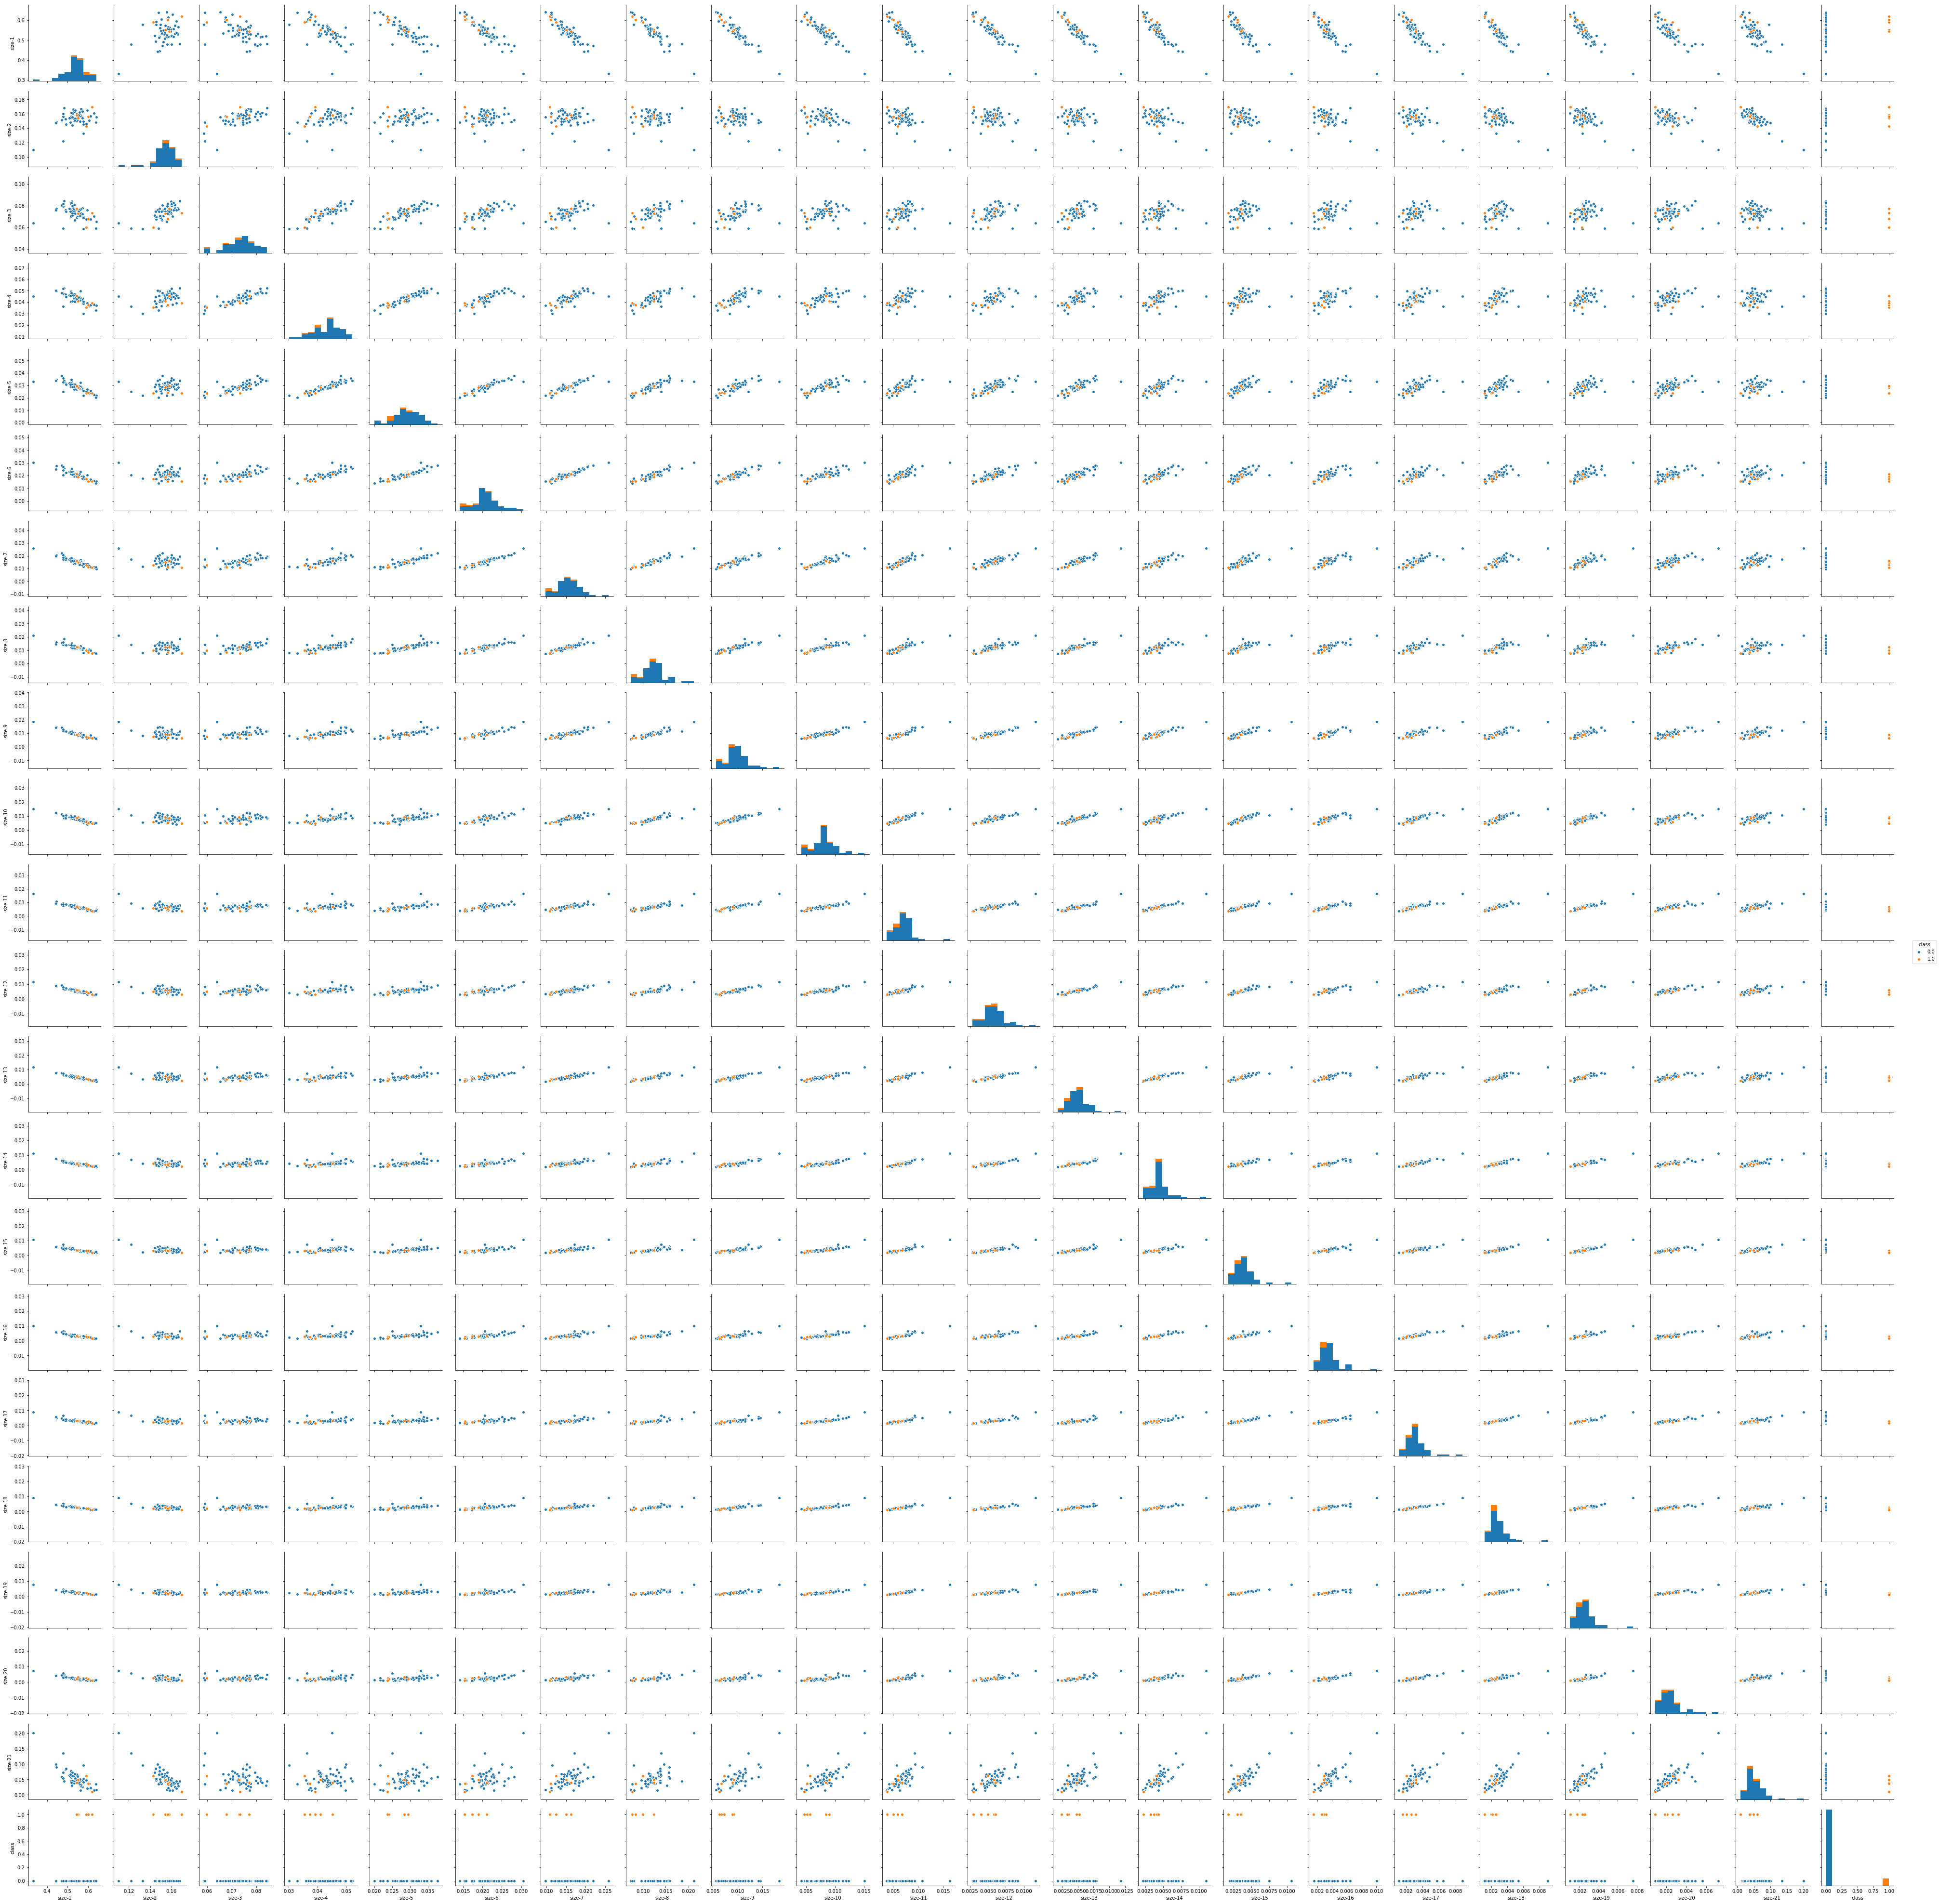

In [16]:
# This is it! Our real dataset.
X = np.empty([59, 21], dtype=np.float32)
y = np.zeros([59, 1], dtype=np.float32)

positives = []
positive_files = ["./inputs/_outDONEIN736-SN97.txt",
                  "./inputs/_outDONEIN733-SN103.txt",
                  "./inputs/_outDONEIN805-SN126.txt",
                  "./inputs/_outDONEIN793-SN74.txt",
                  "./inputs/_outDONEIN781-SN7.txt"]

# Have to be careful to sort the results of glob - it does not guarantee an ordering for what it returns
for i, file in enumerate(sorted(glob.glob("./inputs/*.txt"))):
    f = open(file,'r')
   
    if file in positive_files:
        positives.append(i)
        y[i] = 1

    lines = f.readlines()[4:]
    arr = np.zeros(21, dtype=np.float32)
    for x, line in enumerate(lines):
        arr[x] = int(line.split(',')[1])
    
    my_sum = sum(arr)
    arr = arr / my_sum
#     print(file[9:] + ": " + str(sum(arr)))
    X[i] = arr

features = [("size-" + str(x+1)) for x in range(21)]
features.append("class")

outcome_strings = ['non-fatal', 'fatal']
to_name = lambda x: outcome_strings[int(x)]
# y = np.array([to_name(el) for el in y]).reshape((59, 1))

data = np.append(X, y, axis=1)
X_dataframe = pd.DataFrame(data, columns=features)
g = sb.pairplot(X_dataframe, hue='class')

/Users/soutar/miniconda3/envs/cs4098/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(88, 21) (88, 1)


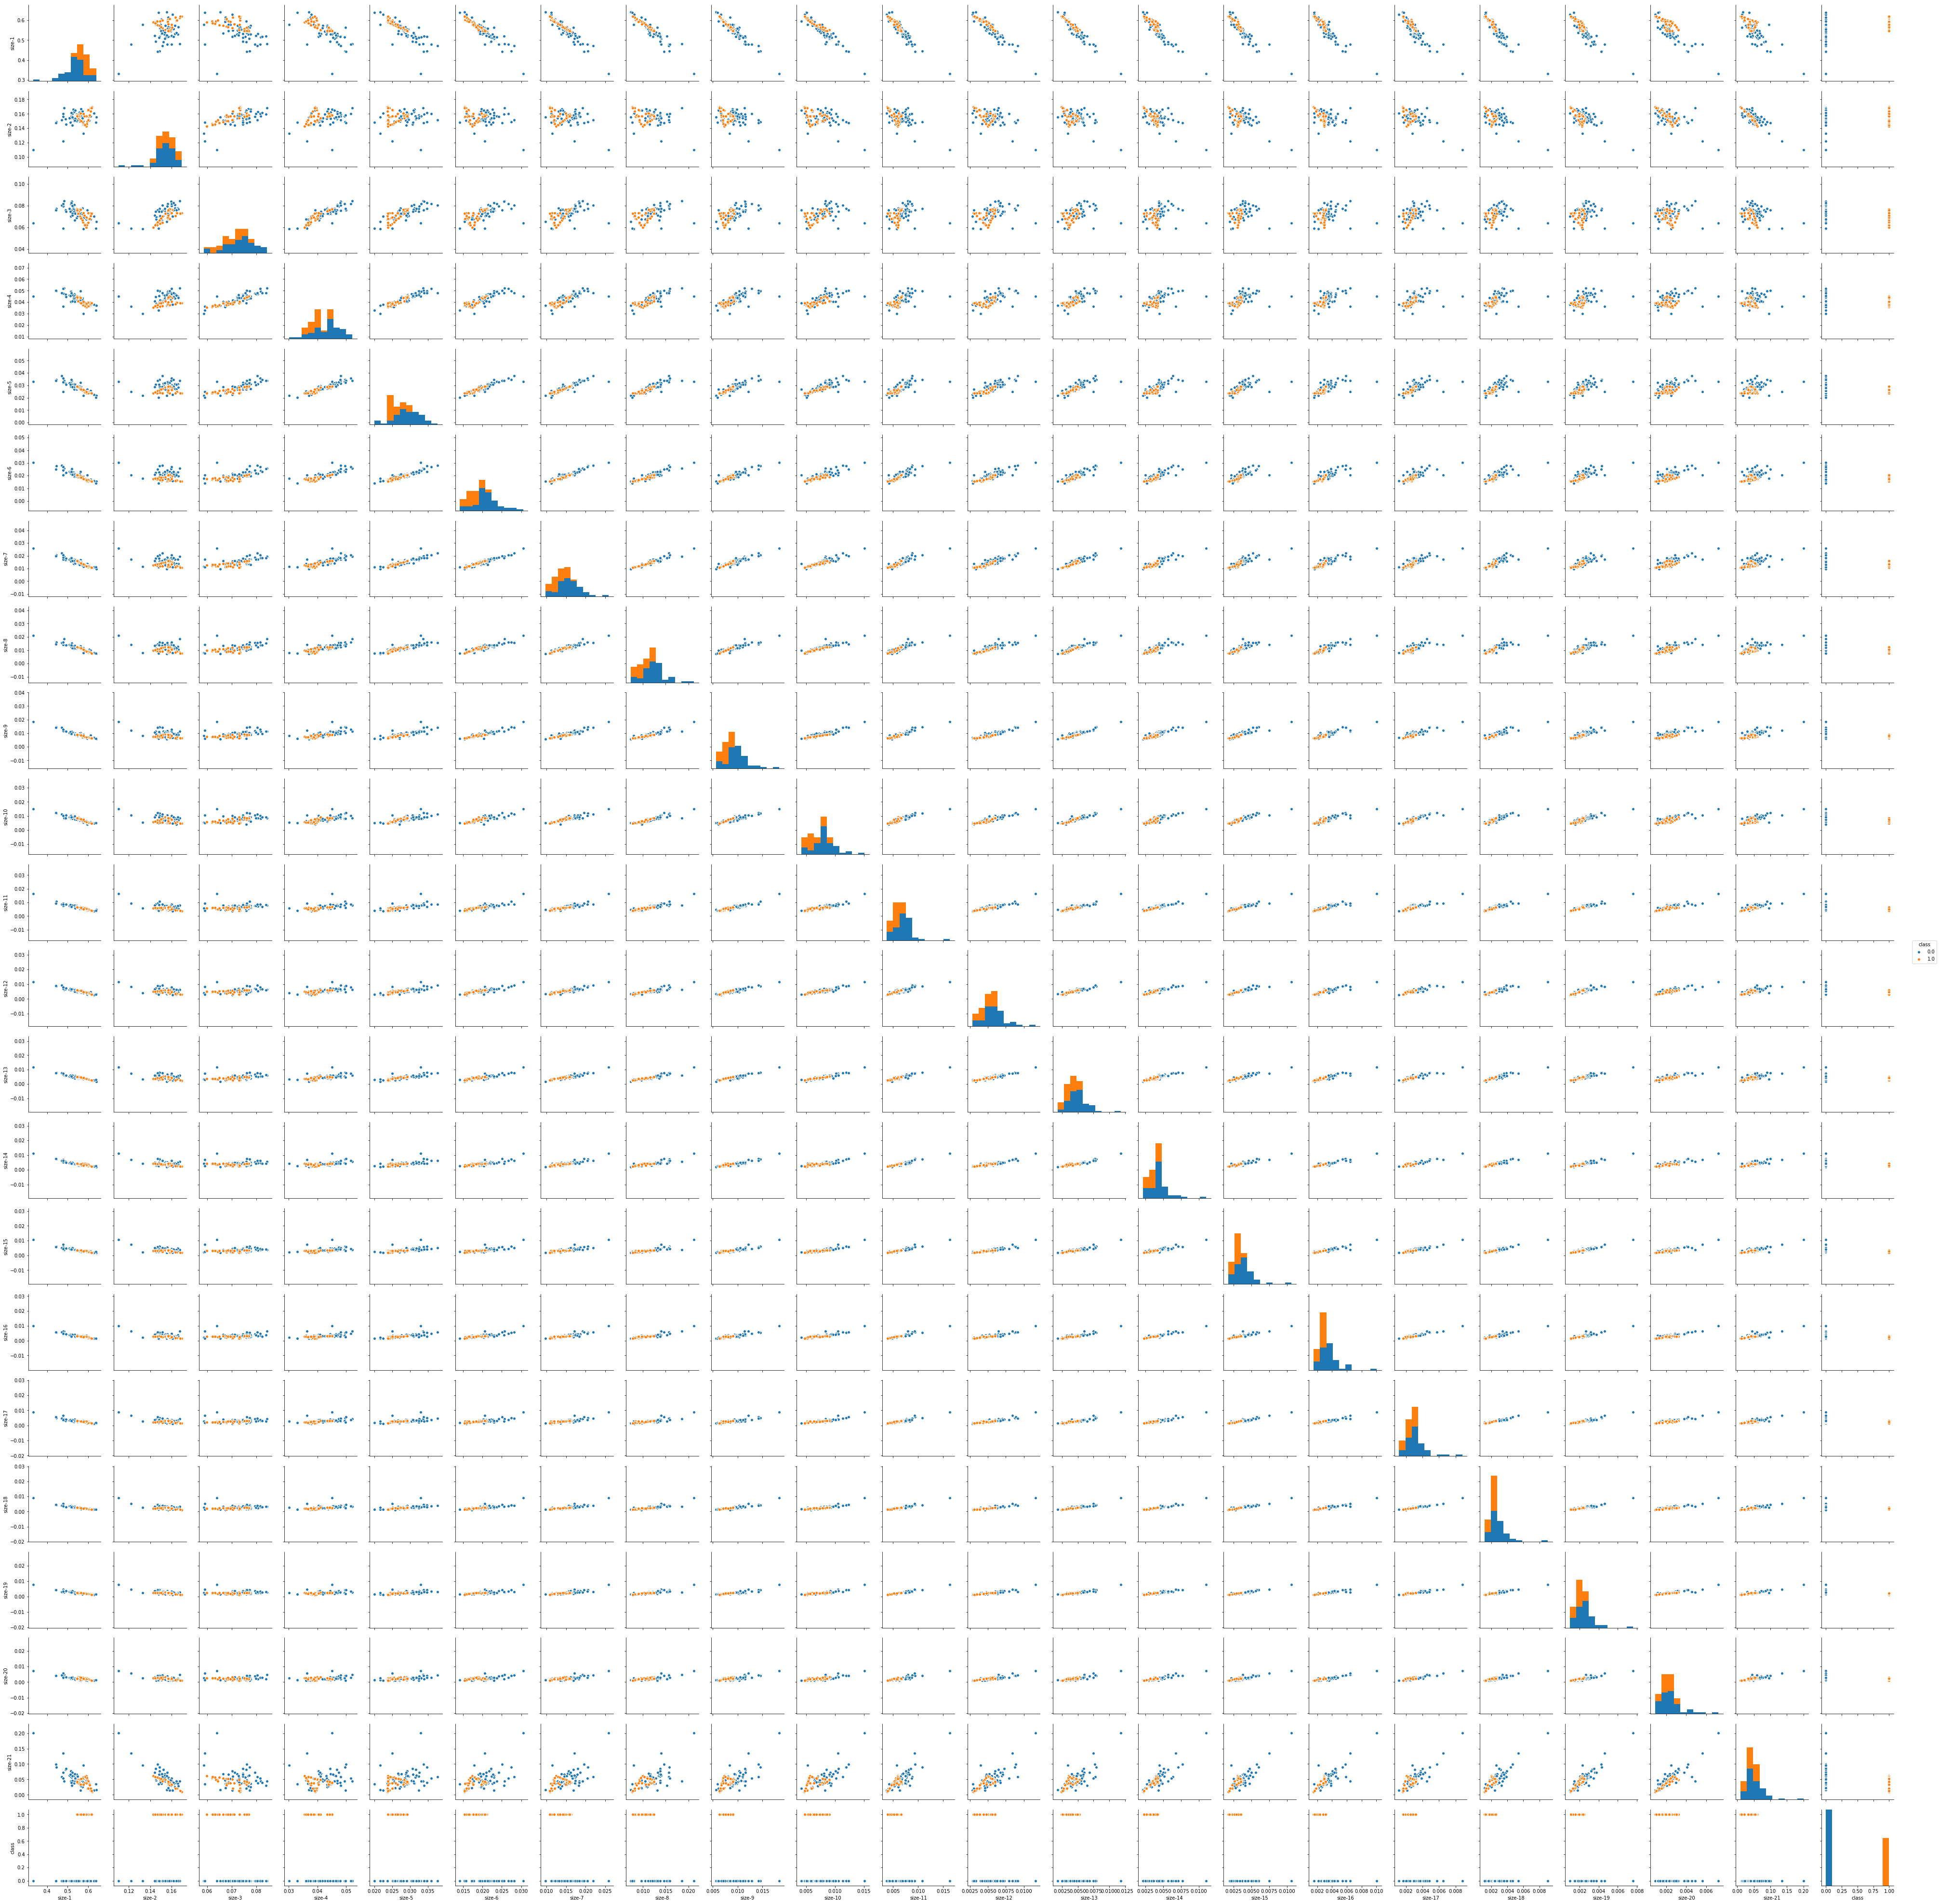

In [17]:
X_minority, X_majority, y_minority, y_majority = np.take(X, positives, axis=0), np.delete(X, positives, axis=0), \
                                                    np.take(y, positives, axis=0), np.delete(y, positives, axis=0)
    
sampler = SMOTE(random_state=0, k_neighbors=4, kind='svm')
X_res, y_res = sampler.fit_sample(X, y)

y_res = y_res.reshape((88, 1))

print(X_res.shape, y_res.shape)

data = np.append(X_res, y_res, axis=1)
X_dataframe = pd.DataFrame(data, columns=features)
g = sb.pairplot(X_dataframe, hue='class')

(59, 625)


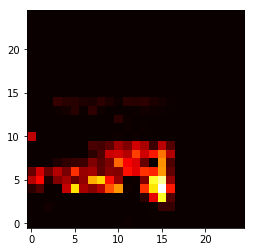

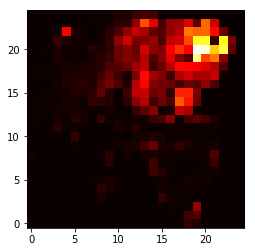

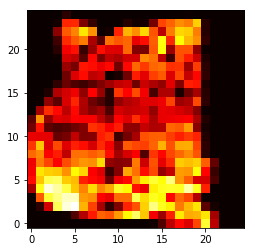

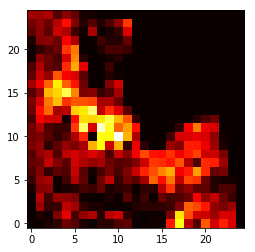

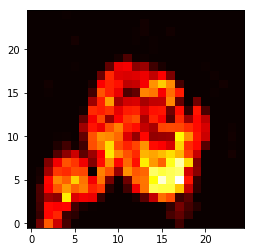

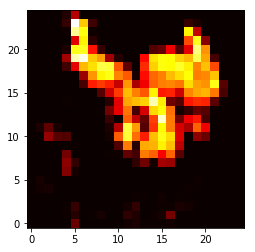

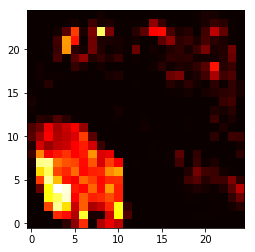

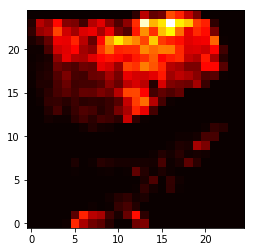

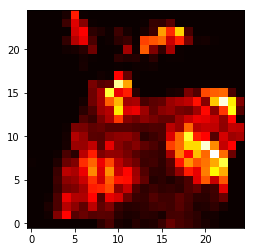

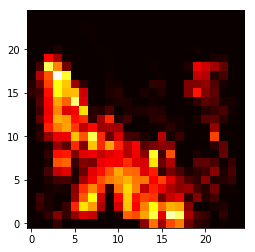

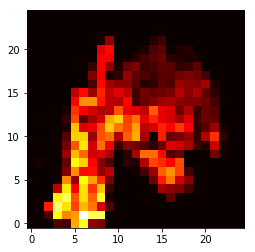

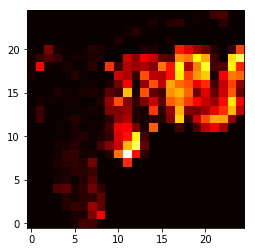

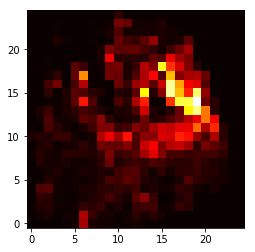

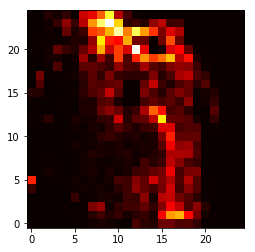

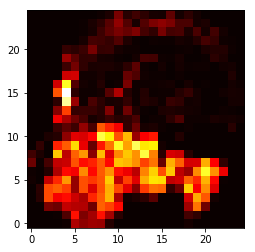

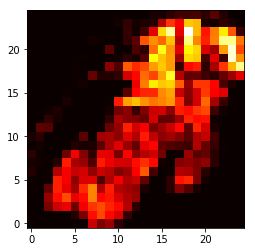

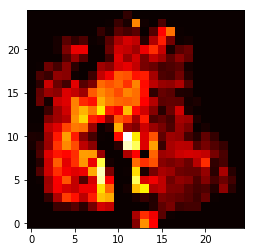

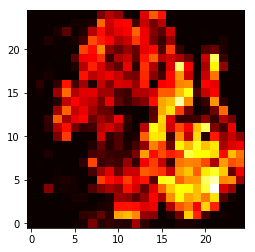

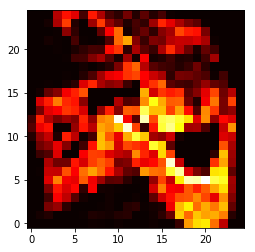

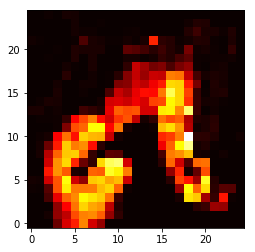

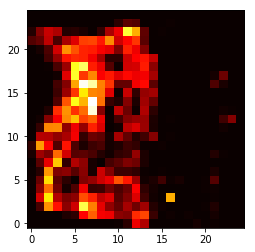

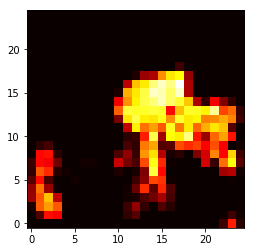

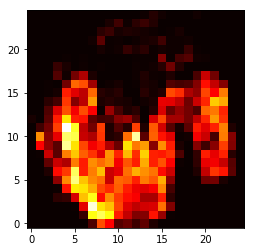

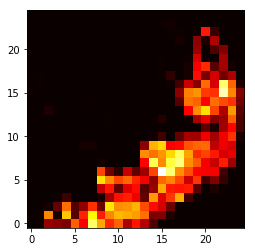

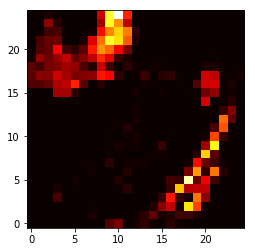

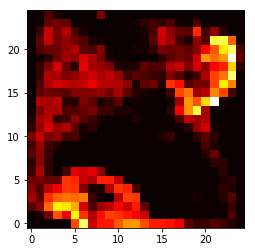

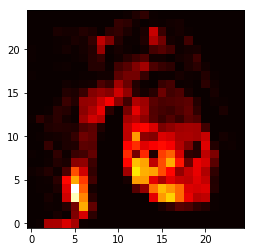

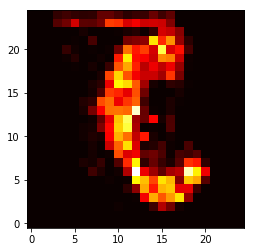

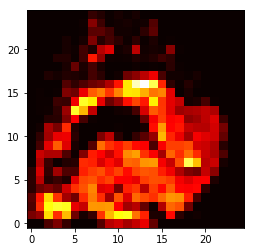

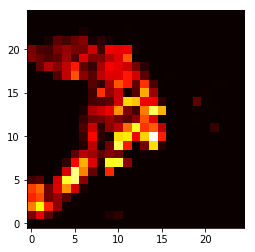

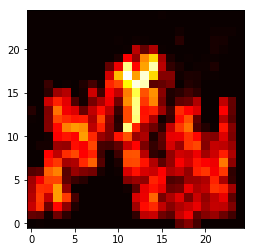

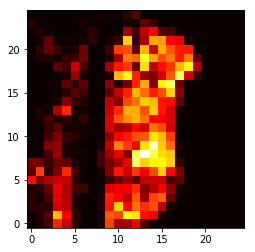

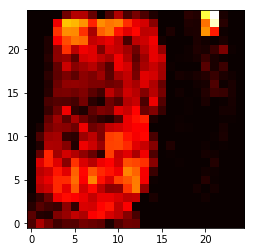

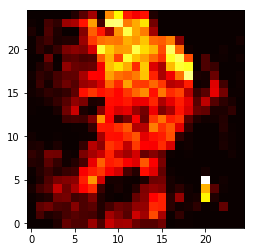

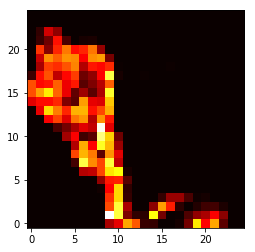

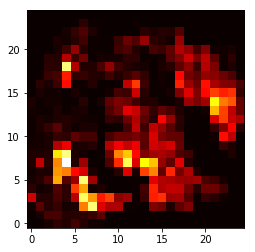

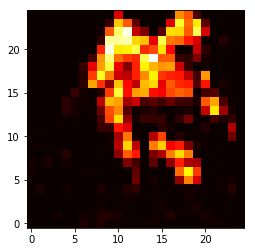

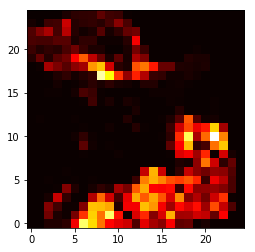

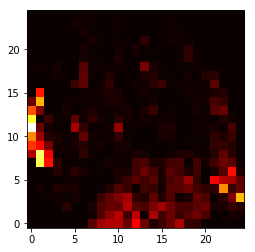

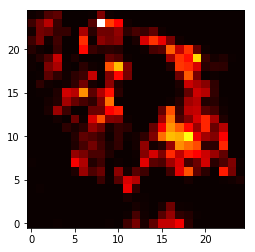

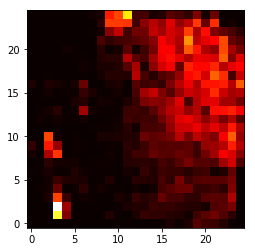

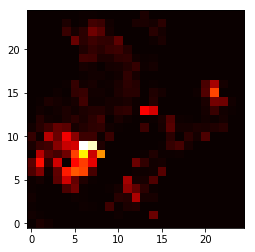

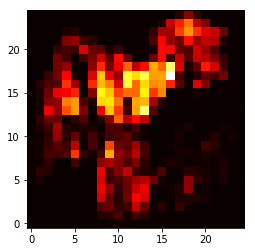

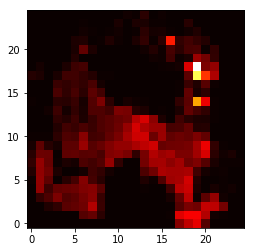

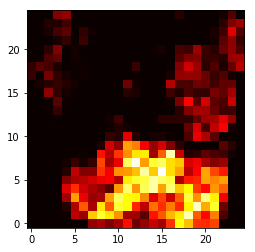

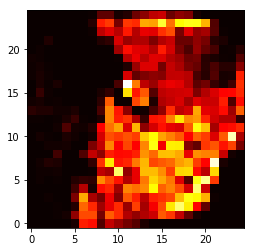

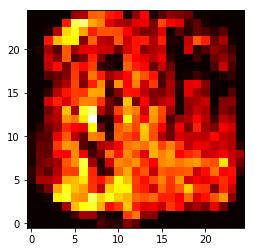

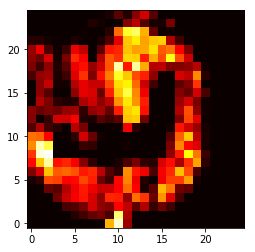

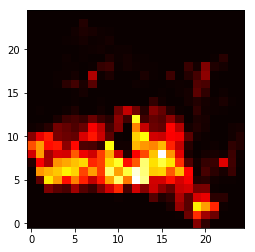

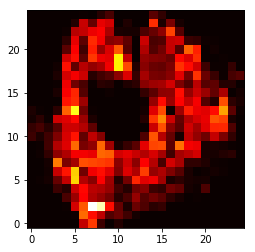

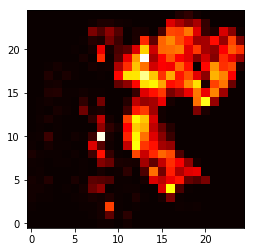

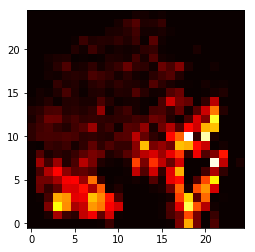

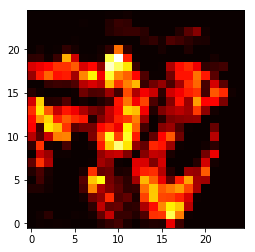

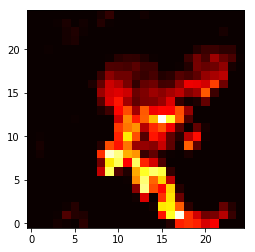

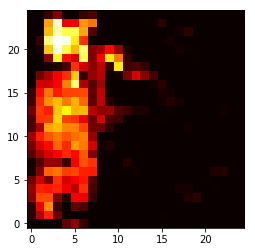

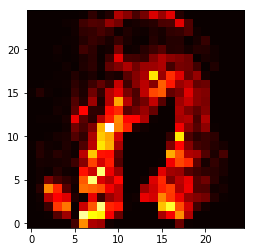

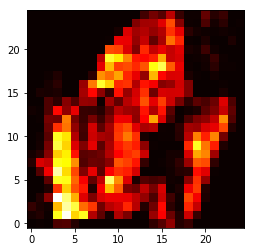

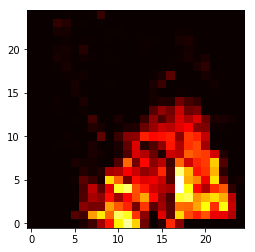

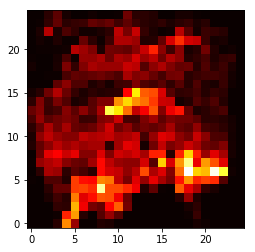

In [18]:
def normalise(arr):
    my_sum = sum(arr)
    mean = my_sum / arr.size
    stddev = np.std(arr)

    arr -= mean
    arr /= stddev

    return arr

heatmaps = np.empty((59, 625))

for i, file in enumerate(sorted(glob.glob("./inputs/spatial/*.txt"))):
    f = open(file,'r')
    lines = f.readlines()
    arr = np.zeros((25, 25), dtype=np.float32)
    
    arr_i = 0
    to_skip = []
    for x, line in enumerate(lines):
        if ']' in line and x not in to_skip:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            arr[arr_i] = np.array([int(s) for s in cleaned.split() if s.isdigit()])
            arr_i += 1
        elif ']' not in line:
            cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
            build_list = [int(s) for s in cleaned.split() if s.isdigit()]
            index = x
            while ']' not in line:
                index += 1
                to_skip.append(index)
                line = lines[index]
                cleaned = ''.join(e for e in line if e.isalnum() or e == ' ')
                build_list.extend([int(s) for s in cleaned.split() if s.isdigit()])
            arr[arr_i] = np.array(build_list)
            arr_i += 1
    
    arr = arr.reshape(625)
    
#     arr = normalise(arr)

    heatmaps[i] = arr
    f.close()

print(heatmaps.shape)
heatmaps_y = np.zeros([59], dtype=np.float32)

for index in positives:
    heatmaps_y[index] = 1

for (i, pair) in enumerate(zip(heatmaps, sorted(glob.glob("./inputs/spatial/*.txt")))):
    (matrix, name) = pair
    temp = np.array([[int(el) for el in matrix]]).reshape(25, 25).transpose()
    fig = plt.figure()
    plt.imshow(temp, cmap='hot', origin='lower')
#     plt.imsave('./inputs/spatial/heatmaps/' + name[17:-4] + '.png', temp, origin='lower', cmap='hot')
    plt.show()

In [19]:
for i, file in enumerate(glob.glob("./inputs/object/*.p")):
    f = open(file,'rb')
    example = pickle.load(f)
    num_clusters = len(example)
    my_sum = 0
    for cluster in example:
        my_sum += len(cluster.cells)
    print(file[16:], "->", num_clusters, ",", my_sum)
    f.close()

_DONEIN700-SN142.p -> 2644 , 13804
_outDONEIN719-SN35.p -> 15096 , 45721
_outDONEIN792-SN73.p -> 25218 , 164323
_outDONEIN796-SN120.p -> 25783 , 86272
_outDONEIN804-SN167.p -> 26332 , 125204
